03/17/2022

Useful Sources:


1.  Qiskit MAX-CUT Solution: https://qiskit.org/textbook/ch-applications/qaoa.html#3.-Approximate-optimization-algorithms-
2. Lucas Paper: https://arxiv.org/pdf/1302.5843.pdf
3. Detailed Explanation of QAOA Algorithm:  https://arxiv.org/abs/1812.03050
4.  Interesting Thesis on Quantum Annealing: https://uwspace.uwaterloo.ca/bitstream/handle/10012/17564/Mohamed_Mayar.pdf?sequence=7
5.  Example Problems: https://qiskit.org/documentation/optimization/tutorials/06_examples_max_cut_and_tsp.html
6. Problem Tutorials: https://qiskit.org/documentation/optimization/tutorials/09_application_classes.html
7. Cited by Lucas (Ref. 39): https://www.sciencedirect.com/science/article/pii/0167637789900436?via=ihub  




QAOA Using Qiskit: Max Flow Min Cut

Install Qiskit and its visualization packages

In [ ]:
!pip install qiskit
!pip install 'qiskit[visualization]'

     |████████████████████████████████| 6.5 MB 3.0 MB/s 
     |████████████████████████████████| 18.0 MB 71 kB/s 
     |████████████████████████████████| 238 kB 44.9 MB/s 
     |████████████████████████████████| 200 kB 46.3 MB/s 
     |████████████████████████████████| 54 kB 1.9 MB/s 
     |████████████████████████████████| 1.6 MB 39.2 MB/s 
     |████████████████████████████████| 49 kB 4.9 MB/s 
     |████████████████████████████████| 37.5 MB 8.7 MB/s 
     |████████████████████████████████| 943 kB 40.0 MB/s 
     |████████████████████████████████| 38.1 MB 1.4 MB/s 
     |████████████████████████████████| 49 kB 4.4 MB/s 
     |████████████████████████████████| 3.6 MB 28.9 MB/s 
     |████████████████████████████████| 113 kB 40.4 MB/s 
  Created wheel for qiskit: filename=qiskit-0.34.2-py3-none-any.whl size=11805 sha256=9c564cfb3e3cca6ab16d4fe12ef747b44c44a178ca282521984a2c57f9994b5b
  Stored in directory: /root/.cache/pip/wheels/62/77/65/cda6eedfdd2a525bd3f479a4386930ae3088a1eb01f8c94

Import necessary libraries

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy.spatial import Delaunay

Set a random seed overall

In [ ]:
np.random.seed(45)

Take in Data or create your own data. I Created my own, chose 15 points, and used the Delauney tessleation package to generate edges for me. You feed the networkx graph nodes with locations and edges which are ordered pairs defining how to connect the numbered nodes.

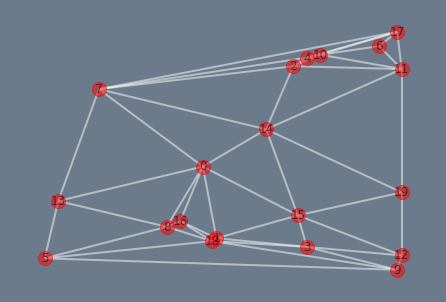

In [ ]:
number_of_points = 20
# Create Data
np.random.seed(0)
x_coord = np.random.randint(0,100,number_of_points)
np.random.seed(1)
y_coord = np.random.randint(0,100,number_of_points)
points=[]
for i in range(number_of_points):
    points.append((x_coord[i],y_coord[i]))
# Generate Graph With Nodes and Edges
G = nx.Graph()
for i in range(number_of_points): 
    G.add_node(i,pos=points[i])
#pos = random_layout(G, seed)
tri = Delaunay(points)
edges=[]
for i in range(len(tri.simplices)):
    for j in range(3):
        edges.append((tri.simplices[i][j],tri.simplices[i][j+1]) if j!=2 else (tri.simplices[i][j],tri.simplices[i][0]))
G.add_edges_from(edges)
fig = plt.figure()
nx.draw(G, pos=nx.get_node_attributes(G,'pos'), with_labels=True, alpha=0.5, node_color='red', edge_color='w',width=2.0,node_size=200)
fig.set_facecolor("#6C7B8B")

Note there are $2^n$ possible choices for the max cut problem where $n$ is the number of nodes.

The Hamiltonian Acts on each Quibit

For n qubits (nodes in our case), $U(H_B) =e^{-i\beta H_B} =e^{-i\beta X_0} \cdots e^{-i\beta X_{n-1}}$, which corrresponds to an $X$ rotation on each qubit. The general Hamiltonian and objective function we try to maximize for the max cut problem is $H = \sum_{(j,k)\in E} \frac{1}{2} (1-s_js_k)$ where $(j,k)$ represent edges in the set of edges $E$. 

Lucas: $H = H_A + H_B$ $\to$ Qiskit: $H=H_P+H_B$. For Lucas, $H_A = \left( \sum s_i \right)^2 \to 0$ as a constraint the inside sum goes to zero, and $H_B = \sum \frac{1}{2} (1-s_is_j)$ = H. In Qiskit, $H_P \sim \frac{1}{2}\sum Z_i \otimes Z_j$, where $Z_i$ are the Pauli $Z$ operators, and $H_B \sim \sum X_i$, where $U(X)$ causes an $X$ rotation on the qubit $i$. $\implies H \sim \sum \frac{1}{2} (2*X_i - Z_jZ_k) \sim H = \sum \frac{1}{2} (1-s_is_j)$ as before. (NOTE: Qiskit Goes on in Appendix.2.1 to Write down our exact Hamiltonian).

The Mixing Unitary

We apply the mixing unitary $U(H_B) =e^{-i\beta H_B}$.

This is the beginning of setting up our quantum circuit. The Hamiltonian is visually reprsented by Hadamard gates that act on each qubit.

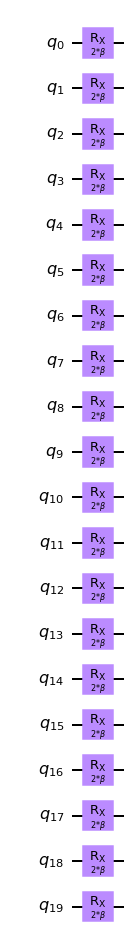

In [ ]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter
from qiskit.tools.visualization import plot_bloch_multivector

# Adjacency is essentially a matrix which tells you which nodes are
# connected. This matrix is given as a sparse matrix, so we need to
# convert it to a dense matrix
adjacency = nx.adjacency_matrix(G).todense()

nqubits = number_of_points

beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_mix.rx(2 * beta, i)

%matplotlib inline
qc_mix.draw(output='mpl')

The Problem Unitary

Apply the unitary $U(H_P) =e^{-i\gamma H_P}$. (This corresponds to the problem Hamiltonian)

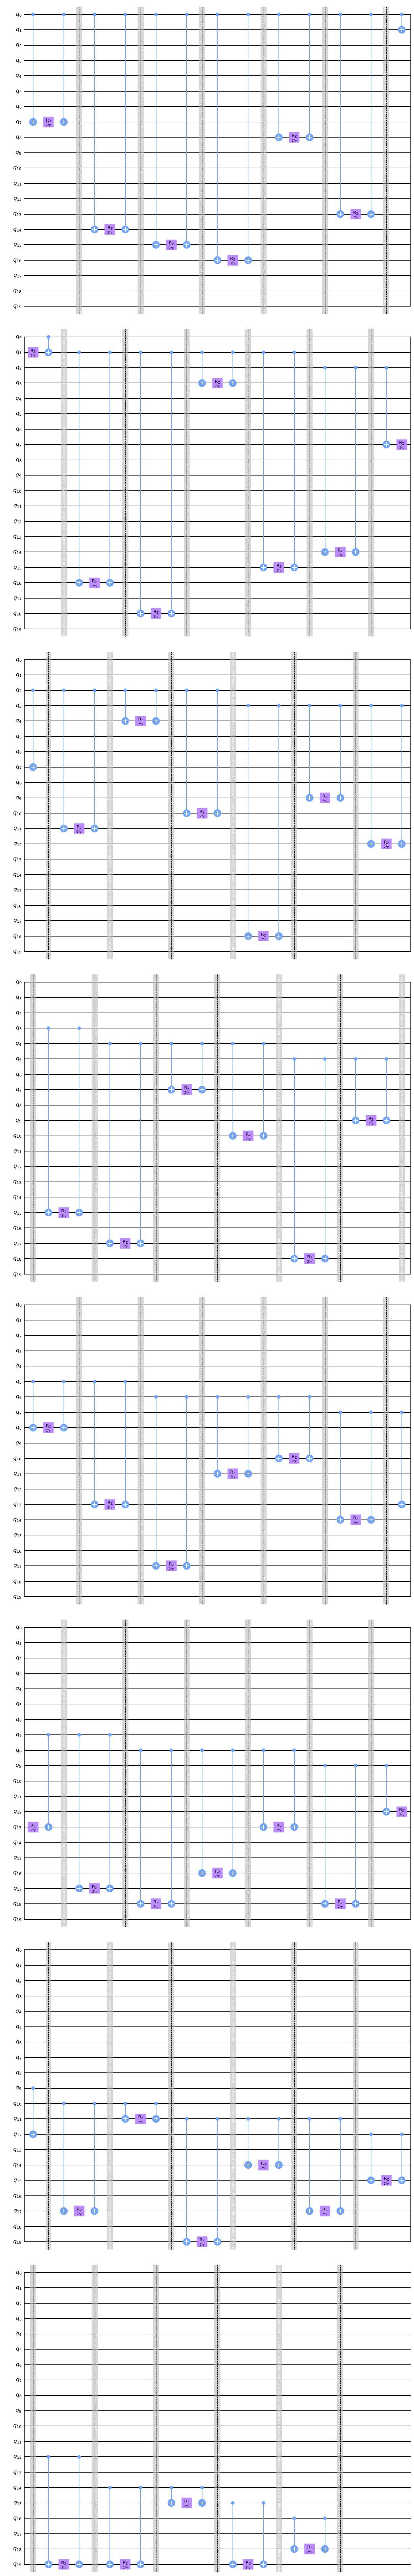

In [ ]:
gamma = Parameter("$\\gamma$")
qc_p = QuantumCircuit(nqubits)
for pair in list(G.edges()):  # pairs of nodes
    qc_p.rzz(2 * gamma, pair[0], pair[1])
    qc_p.barrier()

qc_p.decompose().draw(output='mpl')

Set the initial state as a superposition of all the possible basis states: $ |\psi_0 \rangle = \left(\frac{|0\rangle + |1\rangle}{\sqrt{2}} \right)^{\otimes n} $. We can prepare this state by applying Hadamard gates to each qubit starting from an all zero state shown below

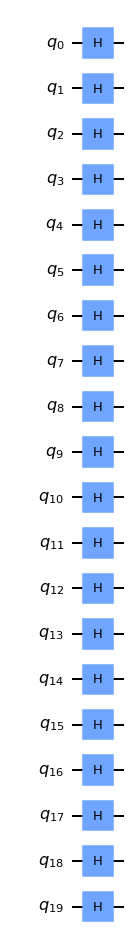

In [ ]:
qc_0 = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_0.h(i)
    
qc_0.draw(output='mpl')

Build QAOA Circuit

Example problem. 1) Prepare intiial state, 2) Apply the Unitary $U$ corresponding to our problem Hamiltonian $H_P$, 3) apply the mixing unitary.

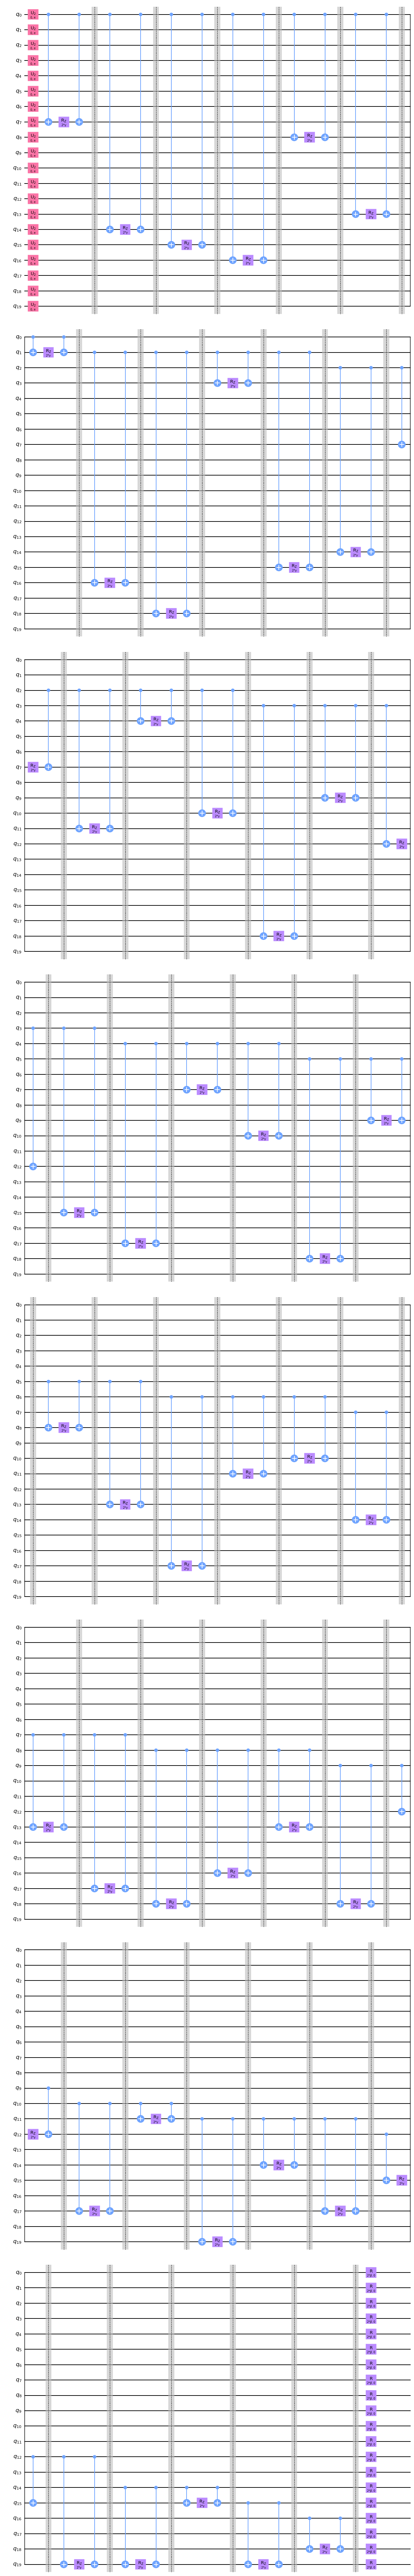

In [ ]:
qc_qaoa = QuantumCircuit(nqubits)

qc_qaoa.append(qc_0, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_p, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_mix, [i for i in range(0, nqubits)])

qc_qaoa.decompose().decompose().draw(output='mpl')

Now, we find the optimal paramters in the exponentials $(\beta_{opt}, \gamma_{opt})$ by minimizing the expectation value of the problem Hamiltonain, i.e. we desire $\langle \psi(\beta_{opt}, \gamma_{opt})|H_P|\psi(\beta_{opt}, \gamma_{opt})\rangle_{\{min\}}|_{\beta,\gamma}$. We find this expectation by performing a measurement in the $z-basis$. We then use a classical optimization algorithm to find the optimal parameters.

1. Initialize Beta and Gamma to reasonable real values.
2. Repeat Until Convergence Criteria Met:


1.   Prepare the initial state $|\psi(\beta, \gamma)\rangle$ using a QAOA circuit.
2.   Measure the state in the standard basis (z-basis here I believe)
3. Compute $\langle H_P \rangle$
4. Find the new paramters $(\beta_{new}, \gamma_{new})$ using classical optimization (Use COBYLA method here)
5. Set paramters to new parameters $\implies$ $(\beta, \gamma) \to (\beta_{new}, \gamma_{new})$






In [ ]:
def maxcut_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    
    Args:
        x: str
           solution bitstring
           
        G: networkx graph
        
    Returns:
        obj: float
             Objective
    """
    obj = 0
    for i, j in G.edges():
      # Min-cut: If the node at i has a different spin than that at j (i.e. in different groups, increase penalty +)
      # Max-cut: If the node at i has a different spin than that at j (i.e. in different groups, increase penalty - negatively)
      if x[i] != x[j]:
        obj +=1
            
    return obj


def compute_expectation(counts, G):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring,G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count


# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(G, theta):
    
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        G: networkx graph
        theta: list
               unitary parameters
                     
    Returns:
        qc: qiskit circuit
    """
    
    nqubits = len(G.nodes())
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        # problem unitary
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep], pair[0], pair[1])

        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
            
    qc.measure_all()
        
    return qc

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(G, p, shots=512):
    
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """
    
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(G, theta)
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=512).result().get_counts()
        
        return compute_expectation(counts, G)
    
    return execute_circ

In [ ]:
from scipy.optimize import minimize


expectation = get_expectation(G, p=1)
res = minimize(expectation, 
                      [1.0, 1.0], 
                      method='COBYLA')
res

     fun: 20.802734375
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 35
  status: 1
 success: True
       x: array([0.6163834 , 0.27671753])

Note that different choices of classical optimizers are present in qiskit.

Analyzing the Result

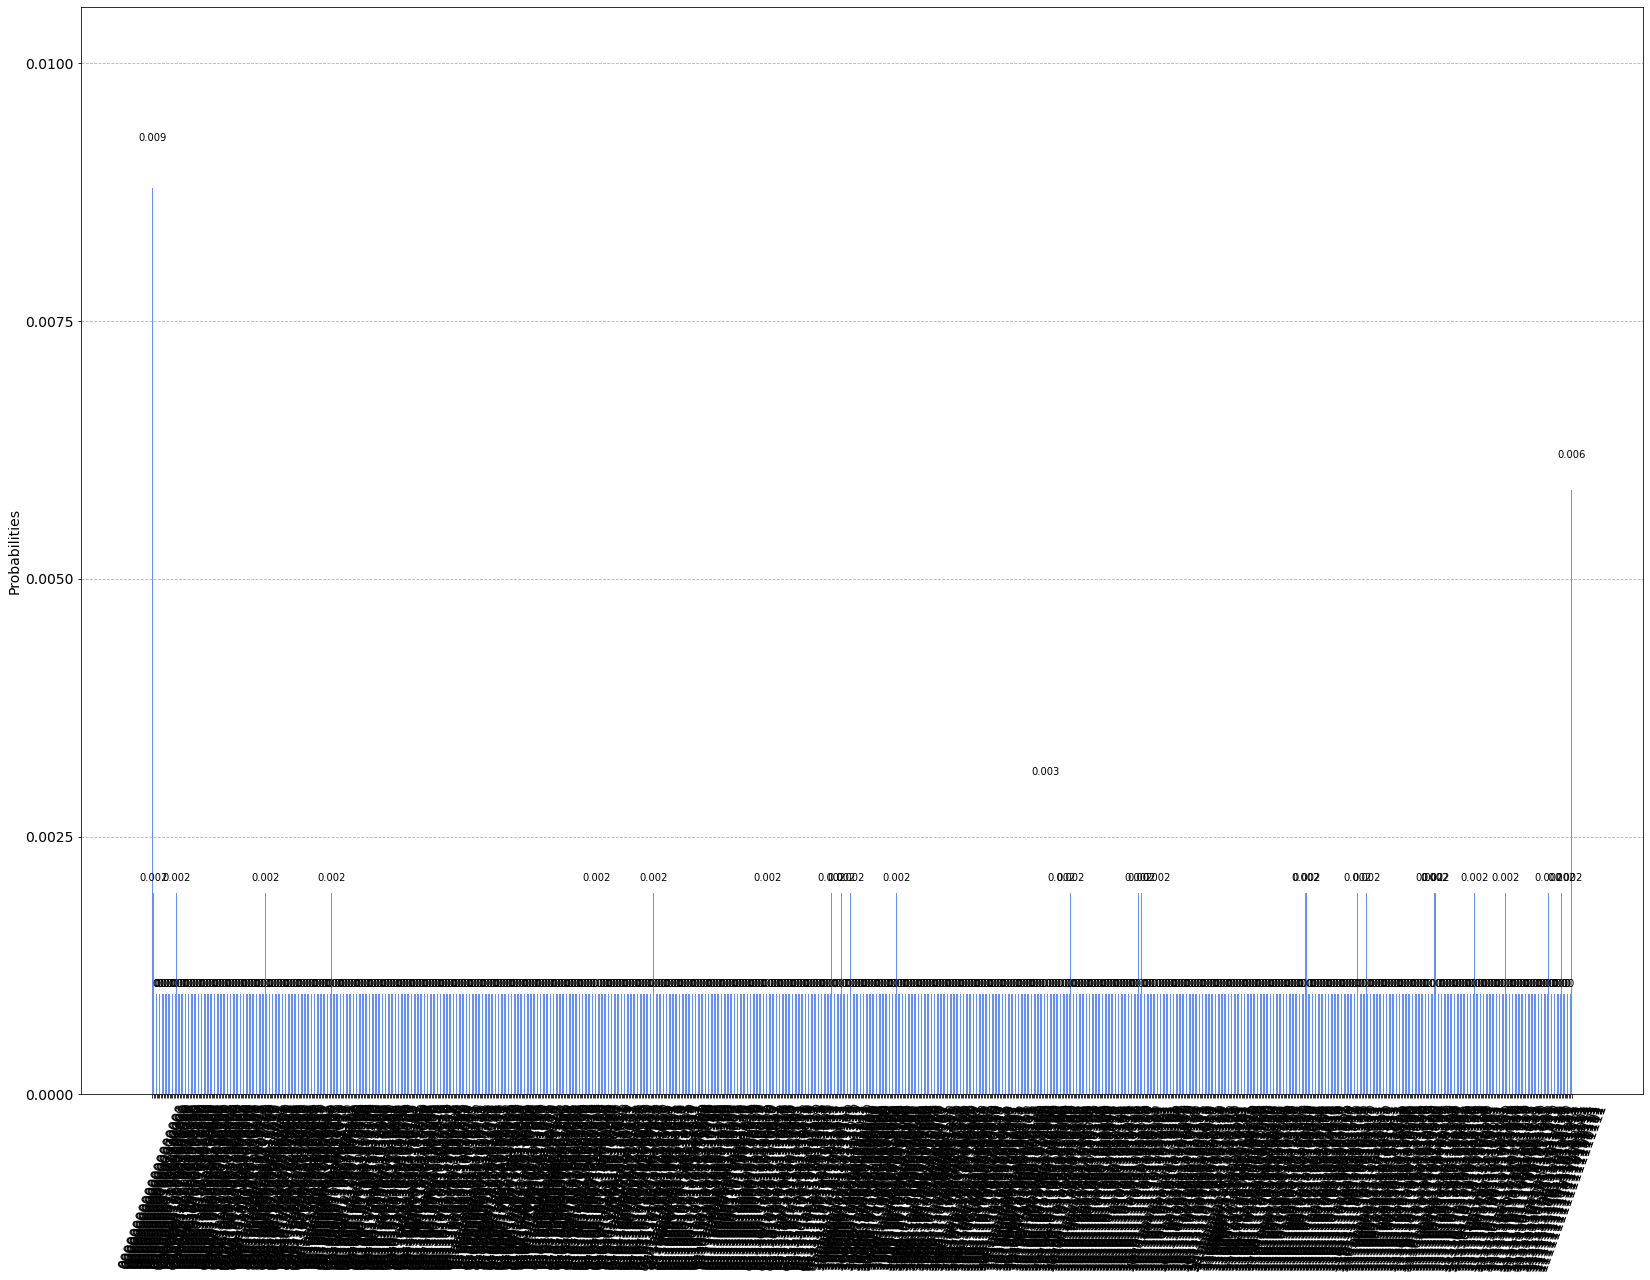

In [ ]:
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = create_qaoa_circ(G, res.x)

counts = backend.run(qc_res, seed_simulator=10).result().get_counts()

sorted_counts = sorted(counts.items(), key=lambda kv: kv[1],reverse=True)
# Find Minimal solution by taking the first solution with two groups of 
# Equal size
counter=0
sol=[]
for i in range(len(sorted_counts)):
  if counter==4:
    break
  else:
    num = str(sorted_counts[i][0])
    x = [int(a) for a in str(num)]
    count_1=0
    count_0=0
    for j in range(len(x)):
      if x[j]==1:
        count_1+=1
      else:
        count_0+=1
    if count_1==count_0:
      counter+=1
      sol.append(sorted_counts[i][0])
    else:
      continue
  
#print('Min Bitstring: '+str(sol)+': '+str(counts[sol]))
# obj += --> obj -= for MAX CUT. ALso, Comment out loop above and just use below to go back to MAX CUT
#print('Max Bitstring: '+str(max(counts,key=counts.get))+': '+str(max(counts.values())))
plot_histogram(counts,figsize=(28,20))

The histogram above plots the probabilities of each bitstring configuration of the graph. The bitstrings form a group of 0's and 1's that correspond in order to the state of each labeled node in our system. The configurtion with the highest probability is what we extract from this data.


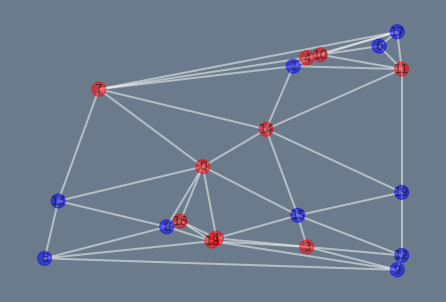

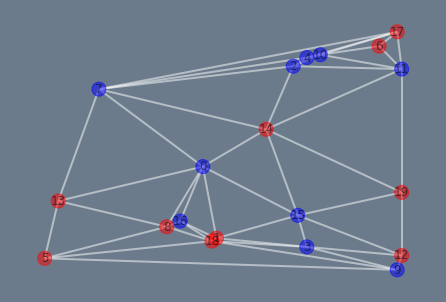

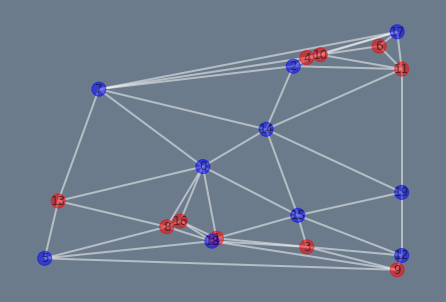

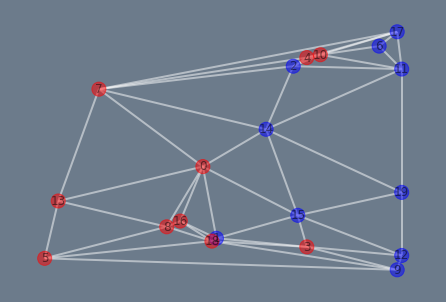

In [ ]:
#from networkx.drawing.nx_agraph import to_agraph
#import pygraphviz


# Take the max bitstring and split it into a list in order to assign a different
# color to each group for plotting the solution MAX CUT
#
#num = str(max(counts,key=counts.get))
#x = [int(a) for a in str(num)]
#
#num = str(max(counts,key=counts.get))  use this for MAX CUT below

# Generate Graphs for top 4 solutions to minimum cut problem

# Solution 1
num = str(sol[0])
x = [int(a) for a in str(num)]
# Generate Graph With Nodes and Edges
G2 = nx.Graph()
for i in range(number_of_points): 
    if x[i]==1:
        G2.add_node(i,pos=points[i],color='red')
    else:
        G2.add_node(i,pos=points[i],color='blue')
colors = [node[1]['color'] for node in G2.nodes(data=True)]
G2.add_edges_from(edges)
fig2 = plt.figure()
nx.draw(G2, pos=nx.get_node_attributes(G2,'pos'), with_labels=True, node_color=colors, edge_color='w', width=2.0,alpha=0.5, node_size=200)
fig2.set_facecolor("#6C7B8B")


# SOlution 2
num = str(sol[1])
x = [int(a) for a in str(num)]
# Generate Graph With Nodes and Edges
G3 = nx.Graph()
for i in range(number_of_points): 
    if x[i]==1:
        G3.add_node(i,pos=points[i],color='red')
    else:
        G3.add_node(i,pos=points[i],color='blue')
colors = [node[1]['color'] for node in G3.nodes(data=True)]
G3.add_edges_from(edges)
fig3 = plt.figure()
nx.draw(G3, pos=nx.get_node_attributes(G3,'pos'), with_labels=True, node_color=colors, edge_color='w', width=2.0,alpha=0.5, node_size=200)
fig3.set_facecolor("#6C7B8B")

# SOlution 3
num = str(sol[2])
x = [int(a) for a in str(num)]
# Generate Graph With Nodes and Edges
G4 = nx.Graph()
for i in range(number_of_points): 
    if x[i]==1:
        G4.add_node(i,pos=points[i],color='red')
    else:
        G4.add_node(i,pos=points[i],color='blue')
colors = [node[1]['color'] for node in G4.nodes(data=True)]
G4.add_edges_from(edges)
fig4 = plt.figure()
nx.draw(G4, pos=nx.get_node_attributes(G4,'pos'), with_labels=True, node_color=colors, edge_color='w', width=2.0,alpha=0.5, node_size=200)
fig4.set_facecolor("#6C7B8B")



# SOlution 4
num = str(sol[3])
x = [int(a) for a in str(num)]
# Generate Graph With Nodes and Edges
G5 = nx.Graph()
for i in range(number_of_points): 
    if x[i]==1:
        G5.add_node(i,pos=points[i],color='red')
    else:
        G5.add_node(i,pos=points[i],color='blue')
colors = [node[1]['color'] for node in G5.nodes(data=True)]
G5.add_edges_from(edges)
fig5 = plt.figure()
nx.draw(G5, pos=nx.get_node_attributes(G5,'pos'), with_labels=True, node_color=colors, edge_color='w', width=2.0,alpha=0.5, node_size=200)
fig5.set_facecolor("#6C7B8B")